# tfidf

Found 148 arguments in the file


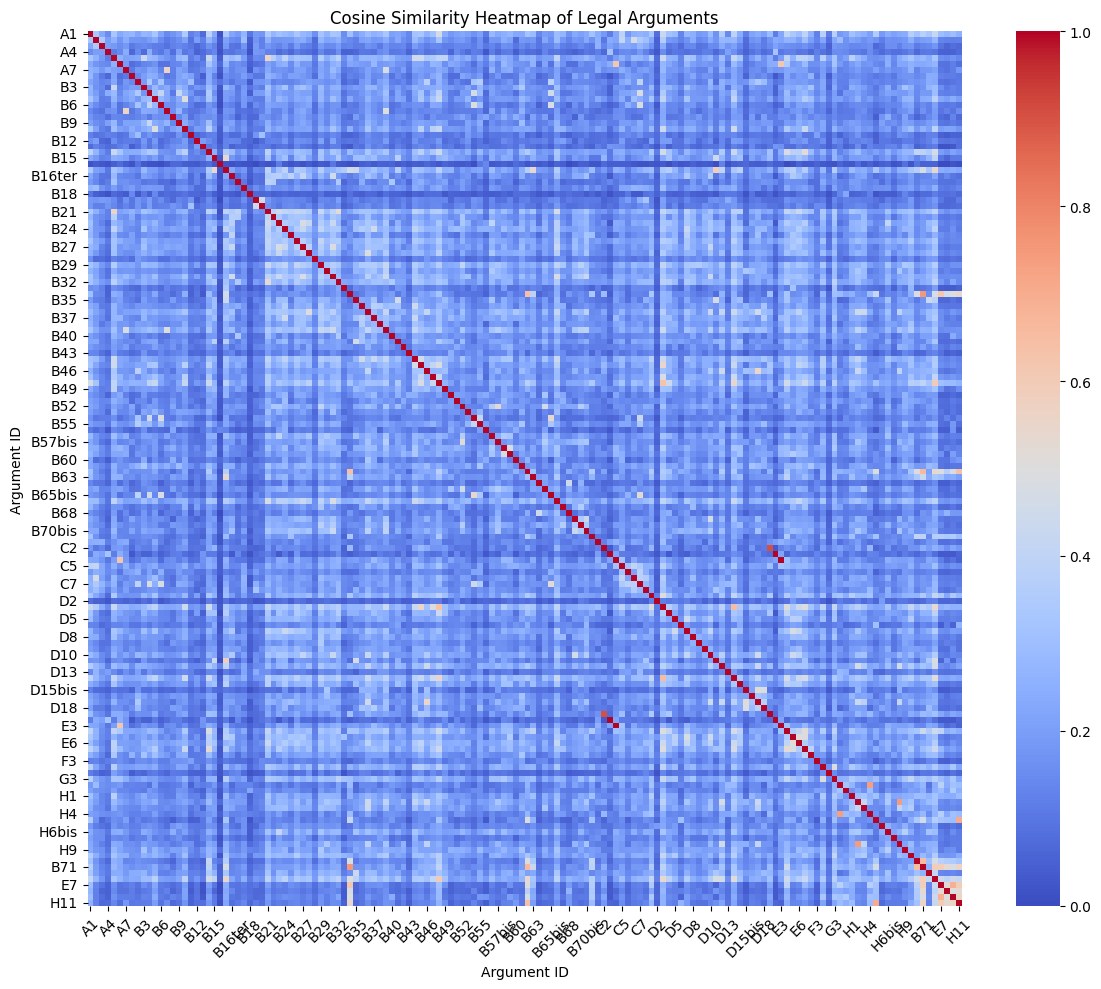

In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Function to read and parse the XML file
def parse_xml_file(file_path):
    try:
        # Try to parse the file directly
        tree = ET.parse(file_path)
        root = tree.getroot()
    except ET.ParseError:
        # If the XML doesn't have a single root element, add a wrapper
        with open(file_path, 'r', encoding='utf-8') as file:
            xml_content = file.read()
        root = ET.fromstring(f'<root>{xml_content}</root>')
    return root

# Extract arguments from XML
def extract_arguments(root):
    arguments = []
    
    # Find all premise and conclusion elements
    for element_type in ['prem', 'conc']:
        for elem in root.findall(f'.//{element_type}'):
            if elem.text:  # Ensure there's text content
                arg_id = elem.attrib.get('ID')
                text = elem.text.strip()
                arg_type = 'Premise' if element_type == 'prem' else 'Conclusion'
                
                # Extract support and attack information
                supports = elem.attrib.get('SUP', '').split('|') if 'SUP' in elem.attrib else []
                attacks = elem.attrib.get('ATT', '').split('|') if 'ATT' in elem.attrib else []
                
                # Remove empty strings from supports and attacks
                supports = [s for s in supports if s]
                attacks = [a for a in attacks if a]
                
                arguments.append({
                    'ID': arg_id,
                    'Text': text,
                    'Type': arg_type,
                    'Supports': supports,
                    'Attacks': attacks
                })
                
    return arguments

# Main function
def generate_cosine_similarity_heatmap(file_path):
    # Parse XML and extract arguments
    root = parse_xml_file(file_path)
    arguments = extract_arguments(root)
    
    # Convert to DataFrame
    arguments_df = pd.DataFrame(arguments)
    
    # Print some information about the arguments
    print(f"Found {len(arguments_df)} arguments in the file")
    
    if arguments_df.empty:
        print("No arguments found in the XML file.")
        return
    
    # Compute TF-IDF vectors for argument texts
    texts = arguments_df['Text'].tolist()
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(texts)
    
    # Compute cosine similarity matrix
    cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
    
    # Convert to DataFrame for better visualization
    cosine_sim_df = pd.DataFrame(
        cosine_sim_matrix, 
        index=arguments_df['ID'], 
        columns=arguments_df['ID']
    )
    
    # Plotting the heatmap without annotations (numbers)
    plt.figure(figsize=(12, 10))
    
    sns.heatmap(
        cosine_sim_df,
        annot=False,  # Disable annotations (numbers)
        cmap="coolwarm",
        cbar=True,
        vmin=0,
        vmax=1
    )
    
    plt.title("Cosine Similarity Heatmap of Legal Arguments")
    plt.xlabel("Argument ID")
    plt.ylabel("Argument ID")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig("argument_similarity_heatmap_no_numbers.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    return cosine_sim_df

if __name__ == "__main__":
    # Execute the main function with the XML file path
    similarity_matrix = generate_cosine_similarity_heatmap("R2021_Prosegur Compañía de Seguridad SA, established in Madrid (Spain) v Commission.xml")


In [4]:
# import xml.etree.ElementTree as ET
# import pandas as pd
# import numpy as np
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Function to read and parse the XML file
# def parse_xml_file(file_path):
#     try:
#         tree = ET.parse(file_path)
#         root = tree.getroot()
#     except ET.ParseError:
#         with open(file_path, 'r', encoding='utf-8') as file:
#             xml_content = file.read()
#         root = ET.fromstring(f'<root>{xml_content}</root>')
#     return root

# # Extract arguments from XML
# def extract_arguments(root):
#     arguments = []
    
#     for element_type in ['prem', 'conc']:
#         for elem in root.findall(f'.//{element_type}'):
#             if elem.text:  # Ensure there's text content
#                 arg_id = elem.attrib.get('ID')
#                 text = elem.text.strip()
#                 arg_type = 'Premise' if element_type == 'prem' else 'Conclusion'
                
#                 # Extract support and attack information
#                 supports = elem.attrib.get('SUP', '').split('|') if 'SUP' in elem.attrib else []
#                 attacks = elem.attrib.get('ATT', '').split('|') if 'ATT' in elem.attrib else []
                
#                 # Remove empty strings from supports and attacks
#                 supports = [s for s in supports if s]
#                 attacks = [a for a in attacks if a]
                
#                 arguments.append({
#                     'ID': arg_id,
#                     'Text': text,
#                     'Type': arg_type,
#                     'Supports': supports,
#                     'Attacks': attacks
#                 })
                
#     return arguments

# # Function to sort arguments by their relationship types
# def sort_arguments_by_relationship(arguments_df):
#     # Create sets to track arguments by relationship type
#     supporting_args = set()
#     attacking_args = set()
    
#     # Identify arguments with support or attack relationships
#     for _, row in arguments_df.iterrows():
#         arg_id = row['ID']
        
#         # If this argument supports others or is supported by others
#         if row['Supports']:
#             supporting_args.add(arg_id)
#             supporting_args.update(row['Supports'])
            
#         # If this argument attacks others or is attacked by others
#         if row['Attacks']:
#             attacking_args.add(arg_id)
#             attacking_args.update(row['Attacks'])
    
#     # Find arguments in both categories
#     mixed_args = supporting_args.intersection(attacking_args)
    
#     # Remove mixed args from individual categories
#     supporting_only = supporting_args - mixed_args
#     attacking_only = attacking_args - mixed_args
    
#     # Arguments with no relationships
#     all_args = set(arguments_df['ID'])
#     related_args = supporting_args.union(attacking_args)
#     no_relation_args = all_args - related_args
    
#     # Create the final sorted list
#     sorted_args = []
#     sorted_args.extend(sorted(list(supporting_only)))  # Support relationships at top
#     sorted_args.extend(sorted(list(mixed_args)))       # Mixed relationships next
#     sorted_args.extend(sorted(list(attacking_only)))   # Attack relationships in middle
#     sorted_args.extend(sorted(list(no_relation_args))) # No relationships at bottom
    
#     return sorted_args

# # Main function
# def generate_sorted_similarity_heatmap(file_path):
#     # Parse XML and extract arguments
#     root = parse_xml_file(file_path)
#     arguments = extract_arguments(root)
    
#     # Convert to DataFrame
#     arguments_df = pd.DataFrame(arguments)
    
#     print(f"Found {len(arguments_df)} arguments in the file")
    
#     if arguments_df.empty:
#         print("No arguments found in the XML file.")
#         return
    
#     # Compute TF-IDF vectors for argument texts
#     texts = arguments_df['Text'].tolist()
#     vectorizer = TfidfVectorizer()
#     tfidf_matrix = vectorizer.fit_transform(texts)
    
#     # Compute cosine similarity matrix
#     cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)
    
#     # Create DataFrame with original order
#     orig_sim_df = pd.DataFrame(
#         cosine_sim_matrix, 
#         index=arguments_df['ID'], 
#         columns=arguments_df['ID']
#     )
    
#     # Get sorted argument order
#     sorted_args = sort_arguments_by_relationship(arguments_df)
#     print("Arguments sorted by relationship:")
#     print("Supporting first:", [arg for arg in sorted_args if arg in sorted(list(set(arguments_df[arguments_df['Supports'].apply(len) > 0]['ID'])))])
#     print("Attacking next:", [arg for arg in sorted_args if arg in sorted(list(set(arguments_df[arguments_df['Attacks'].apply(len) > 0]['ID'])))])
#     print("No relation last:", [arg for arg in sorted_args if arg not in sorted(list(set(arguments_df[arguments_df['Supports'].apply(len) > 0]['ID']))) and arg not in sorted(list(set(arguments_df[arguments_df['Attacks'].apply(len) > 0]['ID'])))])
    
#     # Reindex the similarity matrix with sorted order
#     sorted_sim_df = orig_sim_df.reindex(index=sorted_args, columns=sorted_args)
    
#     # Plotting the sorted heatmap
#     plt.figure(figsize=(12, 10))
    
#     sns.heatmap(
#         sorted_sim_df,
#         annot=False,  # No annotations as requested
#         cmap="coolwarm",
#         cbar=True,
#         vmin=0,
#         vmax=1
#     )
    
#     plt.title("Sorted Cosine Similarity Heatmap of Legal Arguments")
#     plt.xlabel("Argument ID")
#     plt.ylabel("Argument ID")
#     plt.xticks(rotation=45)
#     plt.yticks(rotation=0)
#     plt.tight_layout()
#     plt.savefig("sorted_argument_similarity_heatmap.png", dpi=300, bbox_inches="tight")
#     plt.show()
    
#     return sorted_sim_df

# if __name__ == "__main__":
#     similarity_matrix = generate_sorted_similarity_heatmap("R2021_Prosegur Compañía de Seguridad SA, established in Madrid (Spain) v Commission.xml")
#     print("Analysis complete. Sorted heatmap saved as 'sorted_argument_similarity_heatmap.png'")


# pretrained LegalBERT

Found 148 arguments in the file


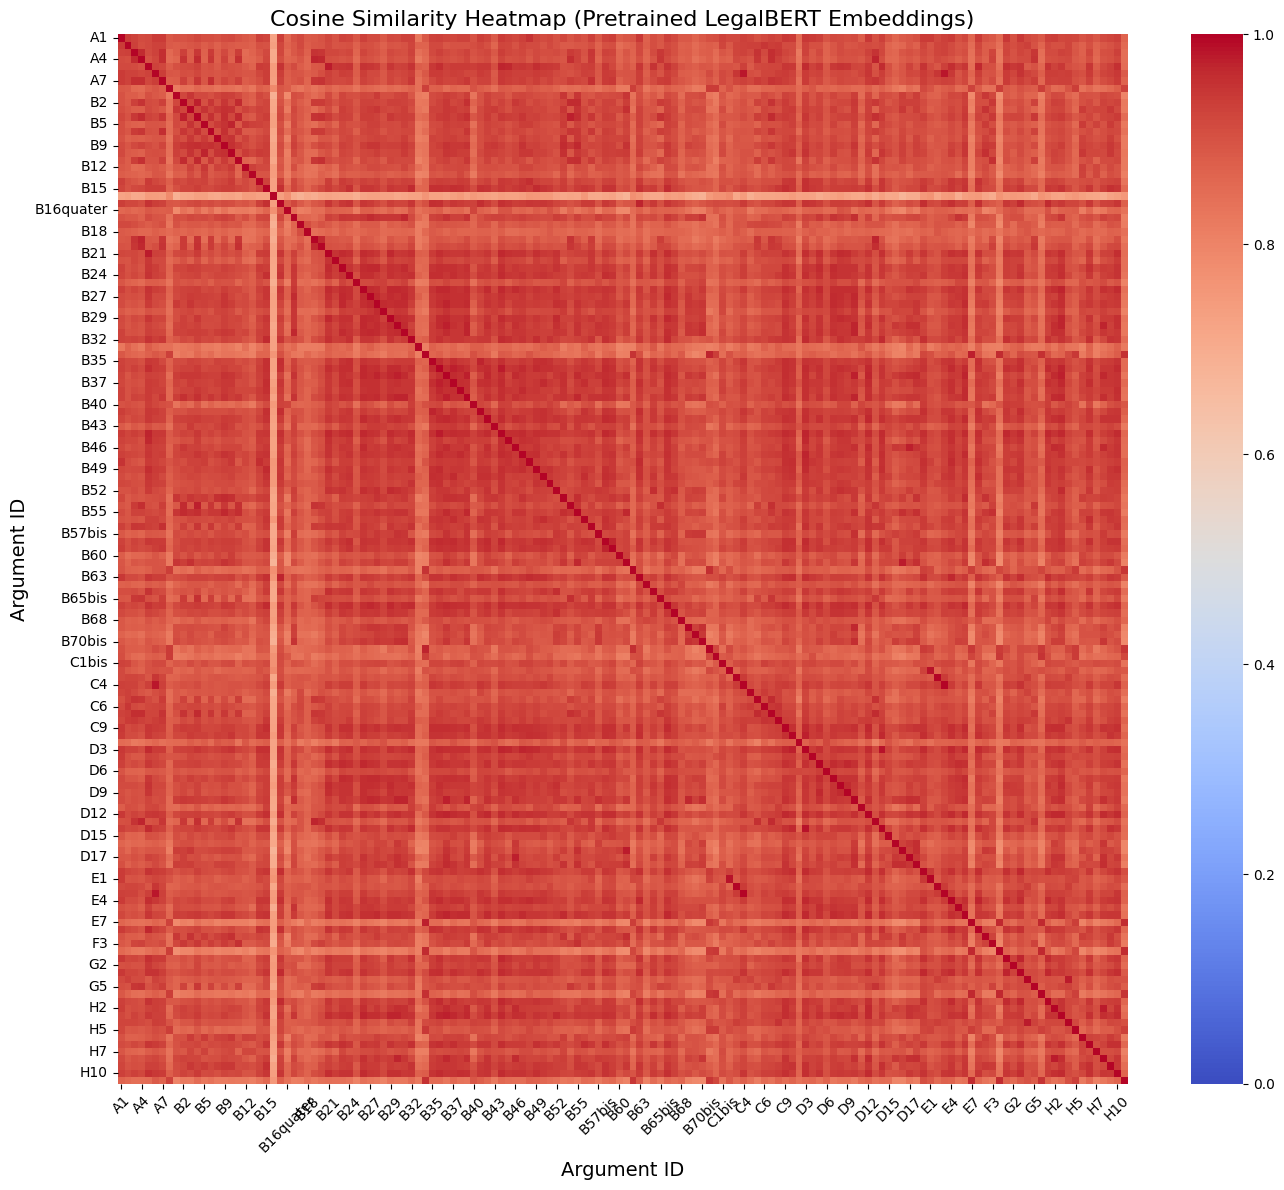

Analysis complete. Sorted heatmap saved as 'roberta_sorted_argument_similarity_heatmap.png'


In [7]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Function to read and parse the XML file
def parse_xml_file(file_path):
    try:
        tree = ET.parse(file_path)
        root = tree.getroot()
    except ET.ParseError:
        with open(file_path, 'r', encoding='utf-8') as file:
            xml_content = file.read()
        root = ET.fromstring(f'<root>{xml_content}</root>')
    return root

# Extract arguments from XML
def extract_arguments(root):
    arguments = []
    
    for element_type in ['prem', 'conc']:
        for elem in root.findall(f'.//{element_type}'):
            if elem.text:  # Ensure there's text content
                arg_id = elem.attrib.get('ID')
                text = elem.text.strip()
                arg_type = 'Premise' if element_type == 'prem' else 'Conclusion'
                
                # Extract support and attack information
                supports = elem.attrib.get('SUP', '').split('|') if 'SUP' in elem.attrib else []
                attacks = elem.attrib.get('ATT', '').split('|') if 'ATT' in elem.attrib else []
                
                # Remove empty strings from supports and attacks
                supports = [s for s in supports if s]
                attacks = [a for a in attacks if a]
                
                arguments.append({
                    'ID': arg_id,
                    'Text': text,
                    'Type': arg_type,
                    'Supports': supports,
                    'Attacks': attacks
                })
                
    return arguments

# Function to get embeddings from RoBERTa model using mean pooling
def get_roberta_embeddings(texts, model_path):
    # Load the RoBERTa model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained('nlpaueb/legal-bert-base-uncased')
    model = AutoModel.from_pretrained('nlpaueb/legal-bert-base-uncased')
    
    # Set model to evaluation mode
    model.eval()
    
    # Initialize a list to store embeddings
    embeddings = []
    
    # Process texts in batches to avoid memory issues
    batch_size = 8
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        
        # Tokenize and prepare input
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
        
        # Get embeddings
        with torch.no_grad():
            outputs = model(**inputs)
            
            # Mean pooling - take the mean of all token embeddings
            attention_mask = inputs['attention_mask']
            token_embeddings = outputs.last_hidden_state
            
            # Expand attention mask to match token embeddings shape
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
            
            # Sum the embeddings weighted by attention mask
            sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
            
            # Divide by sum of attention mask to get mean
            sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
            batch_embeddings = sum_embeddings / sum_mask
            
            # Add to list of embeddings
            for emb in batch_embeddings:
                embeddings.append(emb.numpy())
    
    # Convert to numpy array
    return np.array(embeddings)

# Main function to generate the heatmap with predefined order
def generate_sorted_similarity_heatmap(file_path, model_path, predefined_order):
    # Parse XML and extract arguments
    root = parse_xml_file(file_path)
    arguments = extract_arguments(root)
    
    # Convert to DataFrame
    arguments_df = pd.DataFrame(arguments)
    
    print(f"Found {len(arguments_df)} arguments in the file")
    
    if arguments_df.empty:
        print("No arguments found in the XML file.")
        return
    
    # Get embeddings using RoBERTa model instead of TF-IDF
    texts = arguments_df['Text'].tolist()
    embeddings = get_roberta_embeddings(texts, model_path)
    
    # Compute cosine similarity matrix
    cosine_sim_matrix = cosine_similarity(embeddings, embeddings)
    
    # Create DataFrame with original order
    orig_sim_df = pd.DataFrame(
        cosine_sim_matrix, 
        index=arguments_df['ID'], 
        columns=arguments_df['ID']
    )
    
    # Remove duplicates from predefined order while preserving the order
    seen = set()
    sorted_args = [x for x in predefined_order if not (x in seen or seen.add(x))]
    
    # Filter sorted_args to include only argument IDs that exist in the DataFrame
    sorted_args = [arg for arg in sorted_args if arg in orig_sim_df.index]
    
    # Reindex the similarity matrix with sorted order
    sorted_sim_df = orig_sim_df.reindex(index=sorted_args, columns=sorted_args)
    
    # Plotting the sorted heatmap
    plt.figure(figsize=(14, 12))
    
    sns.heatmap(
        sorted_sim_df,
        annot=False,  # No annotations as requested
        cmap="coolwarm",
        cbar=True,
        vmin=0,
        vmax=1
    )
    
    plt.title("Cosine Similarity Heatmap (Pretrained LegalBERT Embeddings)", fontsize=16)
    plt.xlabel("Argument ID", fontsize=14)
    plt.ylabel("Argument ID", fontsize=14)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.savefig("roberta_sorted_argument_similarity_heatmap.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    return sorted_sim_df

if __name__ == "__main__":
    # Use the predefined order from the user's input
    # supporting_first = ['A2', 'A3', 'A6', 'A8', 'B14', 'B19', 'B2', 'B27', 'B29', 'B3', 'B31', 'B32', 'B37', 'B48', 'B5', 'B50', 'B54', 'B55', 'B58', 'B7', 'B70', 'C6', 'C9', 'D11', 'E1', 'E3', 'F3', 'G3', 'G6', 'H10', 'H11', 'B16bis', 'B33', 'B34', 'B39', 'B40', 'B56', 'B59', 'B62', 'B64', 'B66', 'B68', 'B71', 'C1', 'C4', 'D15bis', 'D19', 'D3', 'D4', 'E7', 'F4', 'H4', 'H5']
    # attacking_next = ['B16bis', 'B64', 'C1', 'D1', 'D15bis', 'D4', 'B15', 'B35', 'B35bis', 'B41', 'B43', 'B63', 'E4', 'F1', 'H1']
    # no_relation_last = ['57bis', 'A1', 'A4', 'A5', 'A7', 'B1', 'B10', 'B11', 'B12', 'B13', 'B16quater', 'B16ter', 'B17', 'B18', 'B20', 'B24', 'B25', 'B26', 'B27bis', 'B28', 'B30', 'B36', 'B38', 'B4', 'B44', 'B45', 'B46', 'B47', 'B49', 'B51', 'B52', 'B53', 'B57', 'B6', 'B60', 'B61', 'B65', 'B65bis', 'B67', 'B69', 'B70bis', 'B8', 'B9', 'C1bis', 'C3', 'C5', 'C5bis', 'C7', 'C8', 'D10', 'D12', 'D13', 'D14', 'D15', 'D16', 'D17', 'D18', 'D2', 'D5', 'D6', 'D7', 'D8', 'D8bis', 'D9', 'E2', 'E6', 'F2', 'G1', 'G2', 'G4', 'G5', 'H2', 'H3', 'H6', 'H6bis', 'H7', 'H8', 'H9', 'C2', 'B16', 'B21', 'B22', 'B23', 'B42', 'B57bis', 'B8bis', 'E5']
    
    # Combine all categories in the requested order
    # predefined_order = supporting_first + attacking_next + no_relation_last
    
    A_group = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8']
    B_group = ['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B16bis', 'B16quater', 'B16ter', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B27bis', 'B28', 'B29', 'B30', 'B31', 'B32', 'B33', 'B34', 'B35', 'B35bis', 'B36', 'B37', 'B38', 'B39', 'B40', 'B41', 'B42', 'B43', 'B44', 'B45', 'B46', 'B47', 'B48', 'B49', 'B50', 'B51', 'B52', 'B53', 'B54', 'B55', 'B56', 'B57', 'B57bis', 'B58', 'B59', 'B60', 'B61', 'B62', 'B63', 'B64', 'B65', 'B65bis', 'B66', 'B67', 'B68', 'B69', 'B70', 'B70bis', 'B71']
    C_group = ['C1', 'C1bis', 'C2', 'C3', 'C4', 'C5', 'C5bis', 'C6', 'C7', 'C8', 'C9']
    D_group = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D8bis', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D15bis', 'D16', 'D17', 'D18', 'D19', 'D2', 'D3', 'D4', 'D5']
    E_group = ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7']
    F_group = ['F1', 'F2', 'F3', 'F4']
    G_group = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6']
    H_group = ['H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H6bis', 'H7', 'H8', 'H9', 'H10', 'H11']
    predefined_order = A_group + B_group + C_group + D_group + E_group + F_group + G_group + H_group

    # Generate the heatmap
    similarity_matrix = generate_sorted_similarity_heatmap("R2021_Prosegur Compañía de Seguridad SA, established in Madrid (Spain) v Commission.xml", "../3 GNN/best_model_legalbert_pc", predefined_order)
    print("Analysis complete. Sorted heatmap saved as 'roberta_sorted_argument_similarity_heatmap.png'")


# finetuned legalbert

Found 148 arguments in the file


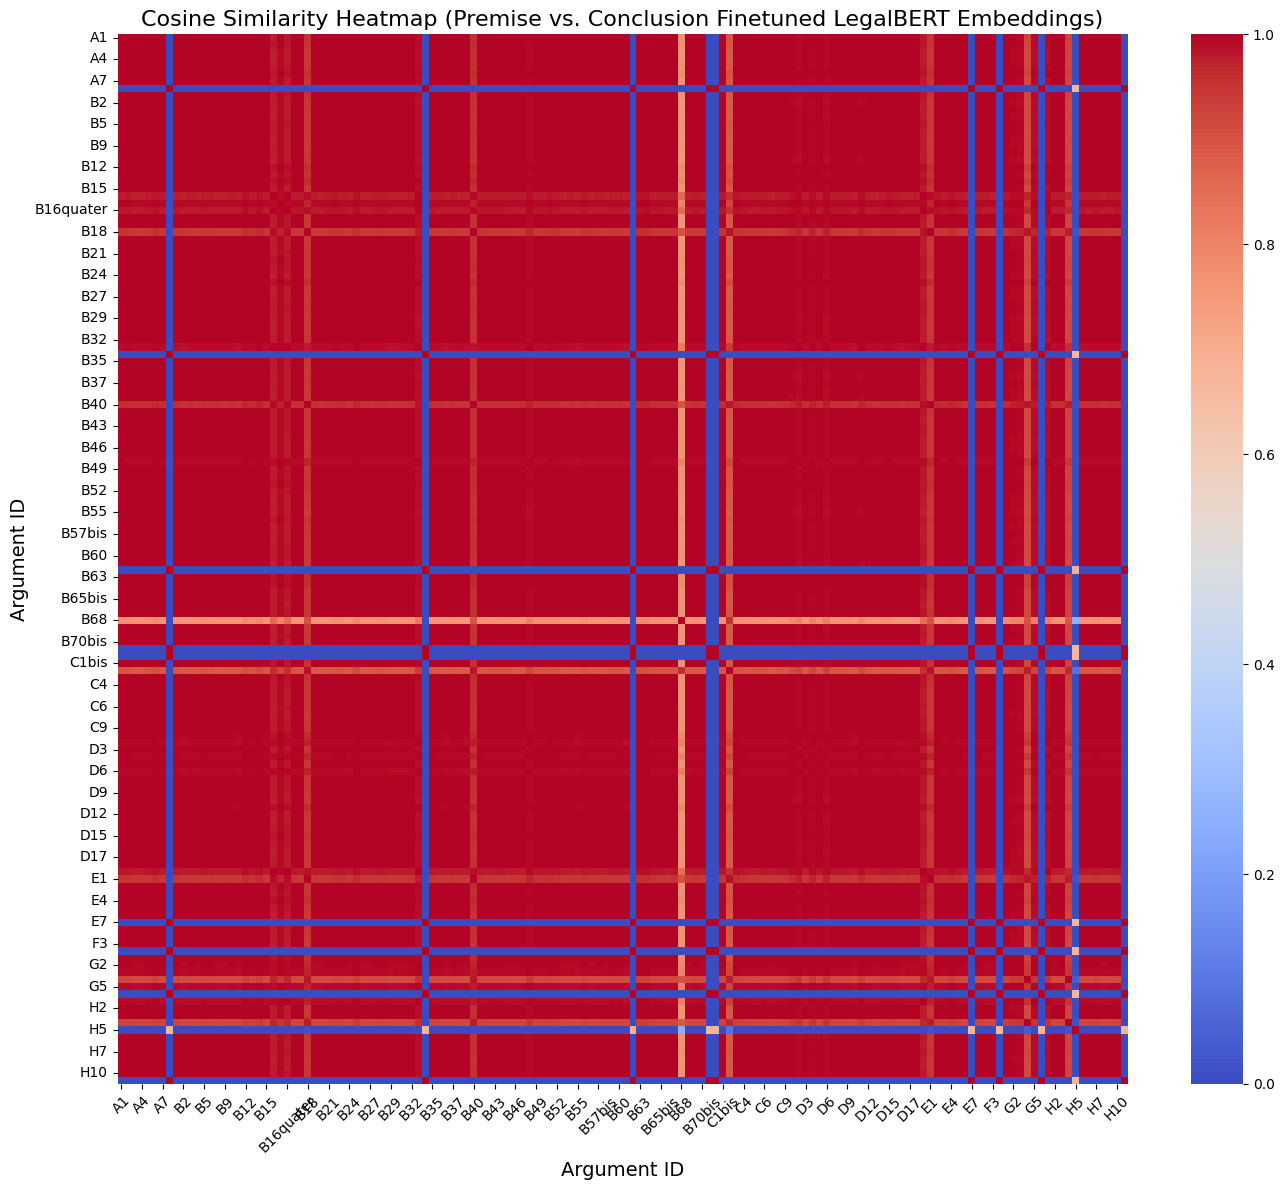

Analysis complete. Sorted heatmap saved as 'roberta_sorted_argument_similarity_heatmap.png'


In [ ]:
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Function to read and parse the XML file
def parse_xml_file(file_path):
    try:
        tree = ET.parse(file_path)
        root = tree.getroot()
    except ET.ParseError:
        with open(file_path, 'r', encoding='utf-8') as file:
            xml_content = file.read()
        root = ET.fromstring(f'<root>{xml_content}</root>')
    return root

# Extract arguments from XML
def extract_arguments(root):
    arguments = []
    
    for element_type in ['prem', 'conc']:
        for elem in root.findall(f'.//{element_type}'):
            if elem.text:  # Ensure there's text content
                arg_id = elem.attrib.get('ID')
                text = elem.text.strip()
                arg_type = 'Premise' if element_type == 'prem' else 'Conclusion'
                
                # Extract support and attack information
                supports = elem.attrib.get('SUP', '').split('|') if 'SUP' in elem.attrib else []
                attacks = elem.attrib.get('ATT', '').split('|') if 'ATT' in elem.attrib else []
                
                # Remove empty strings from supports and attacks
                supports = [s for s in supports if s]
                attacks = [a for a in attacks if a]
                
                arguments.append({
                    'ID': arg_id,
                    'Text': text,
                    'Type': arg_type,
                    'Supports': supports,
                    'Attacks': attacks
                })
                
    return arguments

# Function to get embeddings from RoBERTa model using mean pooling
def get_roberta_embeddings(texts, model_path):
    # Load the RoBERTa model and tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModel.from_pretrained(model_path)
    
    # Set model to evaluation mode
    model.eval()
    
    # Initialize a list to store embeddings
    embeddings = []
    
    # Process texts in batches to avoid memory issues
    batch_size = 8
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        
        # Tokenize and prepare input
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
        
        # Get embeddings
        with torch.no_grad():
            outputs = model(**inputs)
            
            # Mean pooling - take the mean of all token embeddings
            attention_mask = inputs['attention_mask']
            token_embeddings = outputs.last_hidden_state
            
            # Expand attention mask to match token embeddings shape
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
            
            # Sum the embeddings weighted by attention mask
            sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
            
            # Divide by sum of attention mask to get mean
            sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
            batch_embeddings = sum_embeddings / sum_mask
            
            # Add to list of embeddings
            for emb in batch_embeddings:
                embeddings.append(emb.numpy())
    
    # Convert to numpy array
    return np.array(embeddings)

# Main function to generate the heatmap with predefined order
def generate_sorted_similarity_heatmap(file_path, model_path, predefined_order):
    # Parse XML and extract arguments
    root = parse_xml_file(file_path)
    arguments = extract_arguments(root)
    
    # Convert to DataFrame
    arguments_df = pd.DataFrame(arguments)
    
    print(f"Found {len(arguments_df)} arguments in the file")
    
    if arguments_df.empty:
        print("No arguments found in the XML file.")
        return
    
    # Get embeddings using RoBERTa model instead of TF-IDF
    texts = arguments_df['Text'].tolist()
    embeddings = get_roberta_embeddings(texts, model_path)
    
    # Compute cosine similarity matrix
    cosine_sim_matrix = cosine_similarity(embeddings, embeddings)
    
    # Create DataFrame with original order
    orig_sim_df = pd.DataFrame(
        cosine_sim_matrix, 
        index=arguments_df['ID'], 
        columns=arguments_df['ID']
    )
    
    # Remove duplicates from predefined order while preserving the order
    seen = set()
    sorted_args = [x for x in predefined_order if not (x in seen or seen.add(x))]
    
    # Filter sorted_args to include only argument IDs that exist in the DataFrame
    sorted_args = [arg for arg in sorted_args if arg in orig_sim_df.index]
    
    # Reindex the similarity matrix with sorted order
    sorted_sim_df = orig_sim_df.reindex(index=sorted_args, columns=sorted_args)
    
    # Plotting the sorted heatmap
    plt.figure(figsize=(14, 12))
    
    sns.heatmap(
        sorted_sim_df,
        annot=False,  # No annotations as requested
        cmap="coolwarm",
        cbar=True,
        vmin=0,
        vmax=1
    )
    
    plt.title("Cosine Similarity Heatmap (Premise vs. Conclusion Finetuned LegalBERT Embeddings)", fontsize=16)
    plt.xlabel("Argument ID", fontsize=14)
    plt.ylabel("Argument ID", fontsize=14)
    plt.xticks(rotation=45, fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.savefig("roberta_sorted_argument_similarity_heatmap.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    return sorted_sim_df

if __name__ == "__main__":
    # Use the predefined order from the user's input
    # supporting_first = ['A2', 'A3', 'A6', 'A8', 'B14', 'B19', 'B2', 'B27', 'B29', 'B3', 'B31', 'B32', 'B37', 'B48', 'B5', 'B50', 'B54', 'B55', 'B58', 'B7', 'B70', 'C6', 'C9', 'D11', 'E1', 'E3', 'F3', 'G3', 'G6', 'H10', 'H11', 'B16bis', 'B33', 'B34', 'B39', 'B40', 'B56', 'B59', 'B62', 'B64', 'B66', 'B68', 'B71', 'C1', 'C4', 'D15bis', 'D19', 'D3', 'D4', 'E7', 'F4', 'H4', 'H5']
    # attacking_next = ['B16bis', 'B64', 'C1', 'D1', 'D15bis', 'D4', 'B15', 'B35', 'B35bis', 'B41', 'B43', 'B63', 'E4', 'F1', 'H1']
    # no_relation_last = ['57bis', 'A1', 'A4', 'A5', 'A7', 'B1', 'B10', 'B11', 'B12', 'B13', 'B16quater', 'B16ter', 'B17', 'B18', 'B20', 'B24', 'B25', 'B26', 'B27bis', 'B28', 'B30', 'B36', 'B38', 'B4', 'B44', 'B45', 'B46', 'B47', 'B49', 'B51', 'B52', 'B53', 'B57', 'B6', 'B60', 'B61', 'B65', 'B65bis', 'B67', 'B69', 'B70bis', 'B8', 'B9', 'C1bis', 'C3', 'C5', 'C5bis', 'C7', 'C8', 'D10', 'D12', 'D13', 'D14', 'D15', 'D16', 'D17', 'D18', 'D2', 'D5', 'D6', 'D7', 'D8', 'D8bis', 'D9', 'E2', 'E6', 'F2', 'G1', 'G2', 'G4', 'G5', 'H2', 'H3', 'H6', 'H6bis', 'H7', 'H8', 'H9', 'C2', 'B16', 'B21', 'B22', 'B23', 'B42', 'B57bis', 'B8bis', 'E5']
    
    # Combine all categories in the requested order
    # predefined_order = supporting_first + attacking_next + no_relation_last
    
    A_group = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8']
    B_group = ['B1', 'B2', 'B3', 'B4', 'B5', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12', 'B13', 'B14', 'B15', 'B16', 'B16bis', 'B16quater', 'B16ter', 'B17', 'B18', 'B19', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B27bis', 'B28', 'B29', 'B30', 'B31', 'B32', 'B33', 'B34', 'B35', 'B35bis', 'B36', 'B37', 'B38', 'B39', 'B40', 'B41', 'B42', 'B43', 'B44', 'B45', 'B46', 'B47', 'B48', 'B49', 'B50', 'B51', 'B52', 'B53', 'B54', 'B55', 'B56', 'B57', 'B57bis', 'B58', 'B59', 'B60', 'B61', 'B62', 'B63', 'B64', 'B65', 'B65bis', 'B66', 'B67', 'B68', 'B69', 'B70', 'B70bis', 'B71']
    C_group = ['C1', 'C1bis', 'C2', 'C3', 'C4', 'C5', 'C5bis', 'C6', 'C7', 'C8', 'C9']
    D_group = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D8bis', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'D15bis', 'D16', 'D17', 'D18', 'D19', 'D2', 'D3', 'D4', 'D5']
    E_group = ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7']
    F_group = ['F1', 'F2', 'F3', 'F4']
    G_group = ['G1', 'G2', 'G3', 'G4', 'G5', 'G6']
    H_group = ['H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H6bis', 'H7', 'H8', 'H9', 'H10', 'H11']
    predefined_order = A_group + B_group + C_group + D_group + E_group + F_group + G_group + H_group

    # Generate the heatmap
    similarity_matrix = generate_sorted_similarity_heatmap("R2021_Prosegur Compañía de Seguridad SA, established in Madrid (Spain) v Commission.xml", "../3 GNN/best_model_legalbert_pc", predefined_order)
    print("Analysis complete. Sorted heatmap saved as 'roberta_sorted_argument_similarity_heatmap.png'")
